In [1]:

import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
import scipy.stats as st

dt = 0.1
tstart = 0
tlim = 200
t = np.arange(tstart, tlim, 1)


d_cut = 160

ndiv = 1/dt

### keep it always starting at 0
tmoh = np.arange(0, tlim, dt)

N_city = 1

PHU_path = '../../PHU_Data/'
figpath = '../..//figs/predictions/real_2'
datapath = '../../data'

Data = np.zeros([365,4])

files = os.listdir(PHU_path)

target_file1 = f'{PHU_path}/30-Toronto.csv'
target_file2 = f'{PHU_path}/34-York.csv'
target_file3 = f'{PHU_path}/04-Durham.csv'
target_file4 = f'{PHU_path}/22-PeelRegion.csv'
target_file5 = f'{datapath}/toronto_synthetic_data_case2.csv'

Data[:,0] = np.genfromtxt(target_file1, delimiter=',')
Data[:,1] = np.genfromtxt(target_file2, delimiter=',')
Data[:,2] = np.genfromtxt(target_file3, delimiter=',')
Data[:,3] = np.genfromtxt(target_file4, delimiter=',')


population_by_phu = np.genfromtxt(f'{PHU_path}/population_by_phu.csv', delimiter=',')

# x_data = np.genfromtxt(target_file5, delimiter=',')


x_data = Data[:,0]
t_data = np.arange(0,tlim)


# Preallocate compartments
S = np.zeros((len(tmoh),N_city))
E = np.zeros((len(tmoh),N_city))
I = np.zeros((len(tmoh),N_city))
R = np.zeros((len(tmoh),N_city))
D = np.zeros((len(tmoh),N_city))
N = np.zeros((len(tmoh),N_city))


# For noisy synthetic model output
I_model = np.zeros((len(t),N_city))
I_synthetic = np.zeros((len(t),N_city))

 
total = np.zeros((N_city))

 ####### CHANGE HERE ######################
total[0] = population_by_phu[29,1]
 #####################################

# Initial Conditions
 ####### CHANGE HERE ######################
E[0,0] = Data[0,0]
I[0,0] = Data[0,0]
 #####################################
R[0,0] = 0
D[0,0] = 0
N[0,0] = total[0]
S[0,0] = N[0,0] - E[0,0] - I[0,0] - R[0,0] - D[0,0]


# Model parameters - Taken from Southern Ontario - COVID MBE paper
gamma_e = 1/15
gamma_i = 1/5
gamma_r = 1/11
gamma_d = 1/750

beta_e = np.zeros((len(tmoh),N_city)) 
beta_i = np.zeros((len(tmoh),N_city))

beta_calibrated = np.zeros((len(tmoh),N_city))


print("initial infected in PHU1",I[0,0])

print("total population in PHU1",total[0])

#### PEEL - 234 , 1451022

#### Toronto - 430 , 2794356

### York - 212, 1173334

### Durham - 94   - 696992


initial infected in PHU1 430.0
total population in PHU1 2794356.0


In [2]:

# True data

sample_path = '../../data'

# true_path  =  '../../data/toronto_synthetic_truth_all.csv'


# beta_true_path  = '../../data/toronto_synthetic_truth_beta.csv'


# all_truth = np.genfromtxt(true_path, delimiter=',')

# beta_truth = np.genfromtxt(beta_true_path, delimiter=' ')

S_mean = np.zeros((len(tmoh),N_city))
E_mean = np.zeros((len(tmoh),N_city))
I_mean = np.zeros((len(tmoh),N_city))
R_mean = np.zeros((len(tmoh),N_city))
D_mean = np.zeros((len(tmoh),N_city))
beta_mean = np.zeros((len(tmoh),N_city))


# samples = np.loadtxt(f'{sample_path}/muVec_synthetic.dat')

samples = np.loadtxt(f'{sample_path}/muVec_real_case2.dat')

print(samples.shape)

Nsamples = len(samples[0,:])

I_pdf = np.zeros((tlim-d_cut,Nsamples))




for ns in range(Nsamples):


### Toronto
    a0 = samples[0,ns]
    a1 = samples[1,ns]
    t1 =  20
    a2 = samples[2,ns]
    t2 =  35
    a3 =  samples[3,ns]
    t3 = 60
    a4 =  samples[4,ns]
    t4 = 80
    a5 =  samples[5,ns]
    t5 =  140



    beta_i[:,0] = a0  + a1/(1 + np.exp((t1-tmoh))) +  a2/(1 + np.exp((t2-tmoh)))  + a3/(1 + np.exp((t3-tmoh)))  + a4/(1 + np.exp((t4-tmoh)))  + a5/(1 + np.exp((t5-tmoh)))  
                #  + a6/(1 + np.exp((t6-tmoh))) + a7/(1 + np.exp((t7-tmoh))) 
    # + a8/(1 + np.exp((t8-tmoh)))

    beta_mean[:,0] = beta_mean[:,0] + beta_i[:,0]
    

    beta_e[:,0] = beta_i[:,0]

    idxmoh = 0

    #### With mobility tensor   

    FoI = np.zeros((len(tmoh),1))
        
    for kk in range(1,len(tmoh)):

        FoI[kk,0] = beta_e[kk-1,0] * (E[kk-1,0] + I[kk-1,0]) / N[kk-1,0]

        S[kk,0] = S[kk-1,0] + dt*(- FoI[kk,0] * S[kk-1,0])
        E[kk,0] = E[kk-1,0] + dt*(FoI[kk,0]*S[kk-1,0] - (gamma_i + gamma_e)*E[kk-1,0])
        
        I[kk,0] = I[kk-1,0] + dt*(gamma_i*E[kk-1,0] - (gamma_r + gamma_d)*I[kk-1,0])
        R[kk,0] = R[kk-1,0] + dt*(gamma_e*E[kk-1,0] + gamma_r*I[kk-1,0])
        D[kk,0] = D[kk-1,0] + dt*(gamma_d*I[kk-1,0])
        N[kk,0] = S[kk,0] +  E[kk,0] + I[kk,0] + R[kk,0]

 # Compute mean predictions
        S_mean[kk,0] = S_mean[kk,0] + S[kk,0]
        E_mean[kk,0] = E_mean[kk,0] + E[kk,0]
        I_mean[kk,0] = I_mean[kk,0] + I[kk,0]
        R_mean[kk,0] = R_mean[kk,0] + R[kk,0]
        D_mean[kk,0] = D_mean[kk,0] + D[kk,0]
        

        if( kk%ndiv == 0):
            idxmoh = int(kk/ndiv)

            if(idxmoh >= d_cut):

                I_pdf[idxmoh-d_cut,ns] = I[kk,0]



S_mean = S_mean/Nsamples
E_mean = E_mean/Nsamples
I_mean = I_mean/Nsamples
R_mean = R_mean/Nsamples
D_mean = D_mean/Nsamples

beta_mean = beta_mean/Nsamples


(6, 2000)


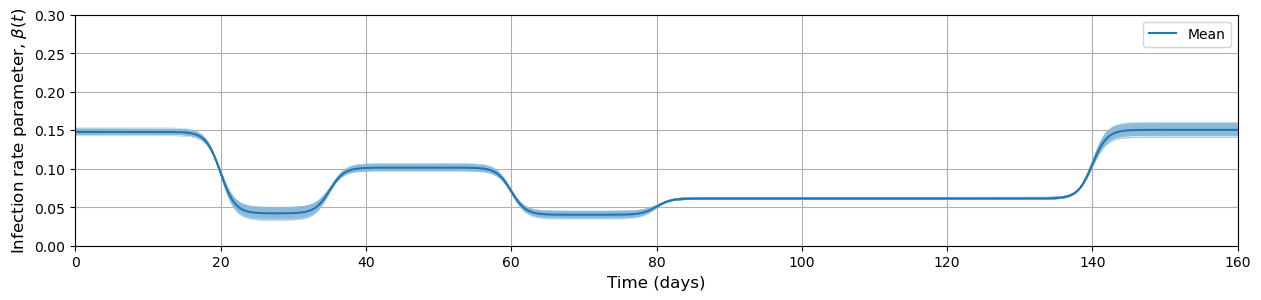

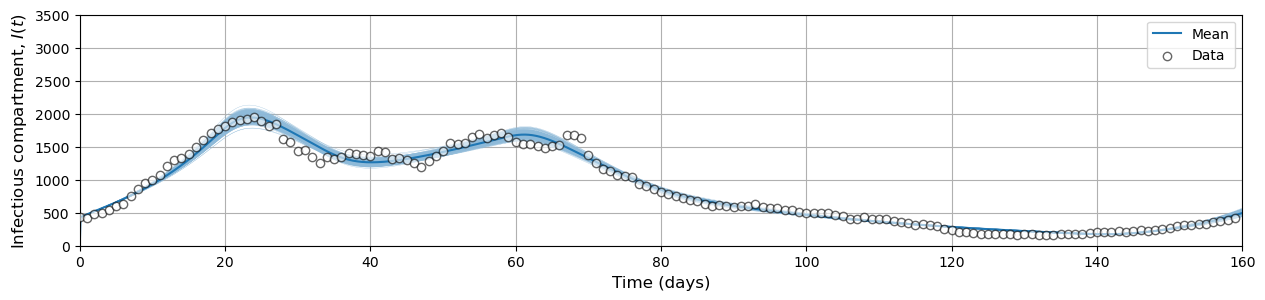

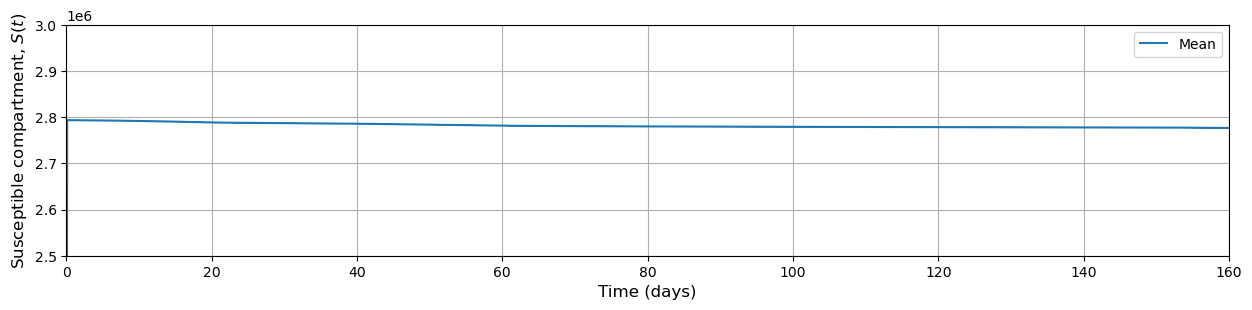

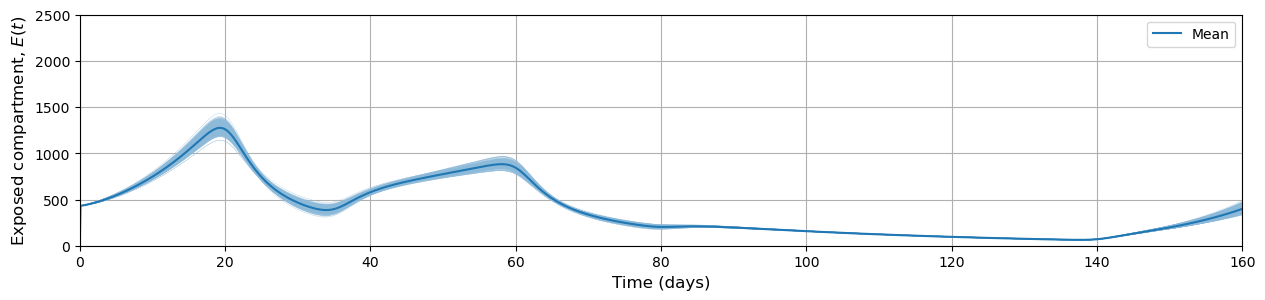

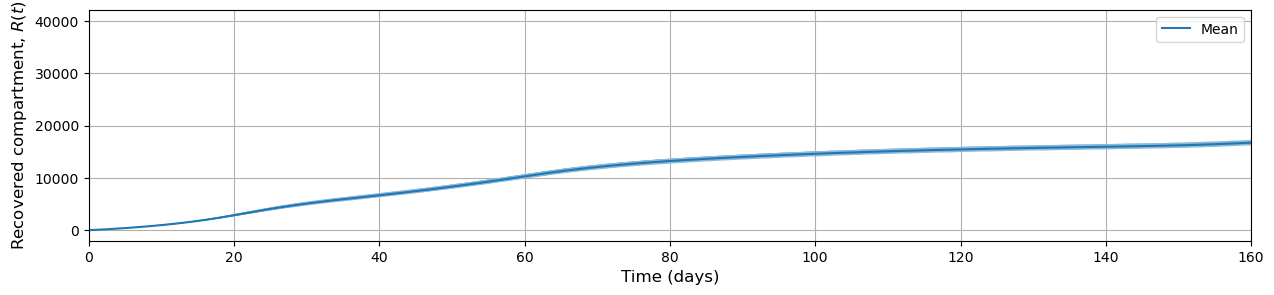

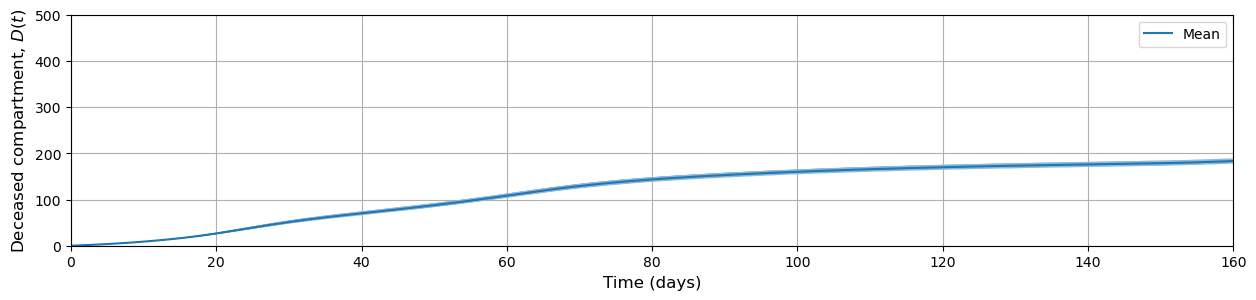

In [3]:
##### Printing beta samples

pred_low = int(tstart*ndiv)

pred_high = int(tlim*ndiv)

Nsamples = 500


for ns in range(Nsamples):


### Toronto
    a0 = samples[0,ns]
    a1 = samples[1,ns]
    t1 =  20
    a2 = samples[2,ns]
    t2 =  35
    a3 =  samples[3,ns]
    t3 = 60
    a4 =  samples[4,ns]
    t4 = 80
    a5 =  samples[5,ns]
    t5 =  140
  


    beta_i[:,0] = a0 + a1/(1 + np.exp((t1-tmoh))) +  a2/(1 + np.exp((t2-tmoh))) + a3/(1 + np.exp((t3-tmoh)))  + a4/(1 + np.exp((t4-tmoh))) + a5/(1 + np.exp((t5-tmoh))) 
                #  + a6/(1 + np.exp((t6-tmoh))) + a7/(1 + np.exp((t7-tmoh))) 
    # + a8/(1 + np.exp((t8-tmoh)))
    beta_e[:,0] = beta_i[:,0]

    if ns == 0:
        beta_append=beta_e
    else:
        beta_append=np.hstack((beta_append,beta_e))

    # ax1.plot(tmoh[pred_low:pred_high], beta_i[pred_low:pred_high,0], color=(142/255,186/255,217/255), linewidth=0.2, label='_nolegend_')


    idxmoh = 0

    #### With mobility tensor   

    FoI = np.zeros((len(tmoh),1))
        
    for kk in range(1,len(tmoh)):

        FoI[kk,0] = beta_e[kk-1,0] * (E[kk-1,0] + I[kk-1,0]) / N[kk-1,0]

        S[kk,0] = S[kk-1,0] + dt*(- FoI[kk,0] * S[kk-1,0])
        E[kk,0] = E[kk-1,0] + dt*(FoI[kk,0]*S[kk-1,0] - (gamma_i + gamma_e)*E[kk-1,0])
        
        I[kk,0] = I[kk-1,0] + dt*(gamma_i*E[kk-1,0] - (gamma_r + gamma_d)*I[kk-1,0])
        R[kk,0] = R[kk-1,0] + dt*(gamma_e*E[kk-1,0] + gamma_r*I[kk-1,0])
        D[kk,0] = D[kk-1,0] + dt*(gamma_d*I[kk-1,0])
        N[kk,0] = S[kk,0] +  E[kk,0] + I[kk,0] + R[kk,0]

    if ns == 0:
        s_append=S[:,0]
        e_append=E[:,0]
        i_append=I[:,0]
        r_append=R[:,0]
        d_append=D[:,0]
    else:
        s_append=np.vstack((s_append,S[:,0]))
        e_append=np.vstack((e_append,E[:,0]))
        i_append=np.vstack((i_append,I[:,0]))
        r_append=np.vstack((r_append,R[:,0]))
        d_append=np.vstack((d_append,D[:,0]))

s_append=s_append.T
e_append=e_append.T
i_append=i_append.T
r_append=r_append.T
d_append=d_append.T


mpl.rcParams.update({'font.size':10})
fig1, ax1 = plt.subplots(figsize=(15, 3))
# ax1.set_xlim([0,40])
# ax1.set_yticks(np.arange(0, 5000, 50.0))
ax1.set_xlabel('Time (days)', fontsize=12)
ax1.set_ylabel(r'Infection rate parameter, $\beta(t)$', fontsize=12)
ax1.plot(tmoh[pred_low:pred_high], beta_append[pred_low:pred_high,:], color=(142/255,186/255,217/255), linewidth=0.2, label='_nolegend_')
ax1.plot(tmoh[pred_low:pred_high], beta_mean[pred_low:pred_high,0], color='tab:blue',linestyle='-', label='Mean')
# ax1.plot(tmoh[pred_low:pred_high], beta_truth[pred_low:pred_high], color='tab:red',linestyle='--', label='Truth')
# ax1.axvline(x=d_cut, color='g', linestyle='--')
# ax1.set_xticks(np.arange(0,50, 10), labels=['0', '10', '20', '30', '40'])
ax1.legend()
ax1.grid()
plt.xlim([0,160])
plt.ylim([0,0.3])
# ax1.figure.savefig(f'{figpath}/beta_synthetic_uncertainty.pdf', bbox_inches='tight')
ax1.figure.savefig(f'{figpath}/beta_real_uncertainty_case2.pdf', bbox_inches='tight')
plt.show()

fig2, ax2 = plt.subplots(figsize=(15, 3))
# ax1.set_xlim([0,40])
# ax1.set_yticks(np.arange(0, 5000, 50.0))
ax2.set_xlabel('Time (days)', fontsize=12)
ax2.set_ylabel(r'Infectious compartment, $I(t)$', fontsize=12)
ax2.plot(tmoh[pred_low:pred_high], i_append[pred_low:pred_high,:], color=(142/255,186/255,217/255), linewidth=0.2, label='_nolegend_')
ax2.plot(tmoh[pred_low:pred_high], I_mean[pred_low:pred_high,0], color='tab:blue',linestyle='-', label='Mean')
plt.scatter(t_data[0:160],x_data[0:160],color='w',edgecolors='k',zorder=3,alpha=0.6,label='Data')
# ax2.plot(tmoh[pred_low:pred_high], all_truth[pred_low:pred_high,2], color='tab:red',linestyle='--', label='Truth')
# ax1.axvline(x=d_cut, color='g', linestyle='--')
# ax1.set_xticks(np.arange(0,50, 10), labels=['0', '10', '20', '30', '40'])
ax2.legend()
ax2.grid()
plt.xlim([0,160])
plt.ylim([0,3500])
# ax2.figure.savefig(f'{figpath}/i_synthetic_uncertainty.pdf', bbox_inches='tight')
ax2.figure.savefig(f'{figpath}/i_real_uncertainty_case2.pdf', bbox_inches='tight')
plt.show()



fig3, ax3 = plt.subplots(figsize=(15, 3))
ax3.set_xlabel('Time (days)', fontsize=12)
ax3.set_ylabel(r'Susceptible compartment, $S(t)$', fontsize=12)
ax3.plot(tmoh[pred_low:pred_high], s_append[pred_low:pred_high,:], color=(142/255,186/255,217/255), linewidth=0.2, label='_nolegend_')
ax3.plot(tmoh[pred_low:pred_high], S_mean[pred_low:pred_high,0], color='tab:blue',linestyle='-', label='Mean')
# ax3.plot(tmoh[pred_low:pred_high], all_truth[pred_low:pred_high,0], color='tab:red',linestyle='--', label='Truth')
# plt.scatter(t_data,x_data[0:160],color='w',edgecolors='k',zorder=1,alpha=0.6,label='Data')
ax3.legend()
ax3.grid()
plt.xlim([0,160])
plt.ylim([2.5e6,3e6])
# ax3.figure.savefig(f'{figpath}/s_synthetic_uncertainty.pdf', bbox_inches='tight')
ax3.figure.savefig(f'{figpath}/s_real_uncertainty_case2.pdf', bbox_inches='tight')
plt.show()




fig4, ax4 = plt.subplots(figsize=(15, 3))
ax4.set_xlabel('Time (days)', fontsize=12)
ax4.set_ylabel(r'Exposed compartment, $E(t)$', fontsize=12)
ax4.plot(tmoh[pred_low:pred_high], e_append[pred_low:pred_high,:], color=(142/255,186/255,217/255), linewidth=0.2, label='_nolegend_')
ax4.plot(tmoh[pred_low:pred_high], E_mean[pred_low:pred_high,0], color='tab:blue',linestyle='-', label='Mean')
# ax4.plot(tmoh[pred_low:pred_high], all_truth[pred_low:pred_high,1], color='tab:red',linestyle='--', label='Truth')
# plt.scatter(t_data,x_data[0:160],color='w',edgecolors='k',zorder=1,alpha=0.6,label='Data')
ax4.legend()
ax4.grid()
plt.xlim([0,160])
plt.ylim([0,2500])
# ax4.figure.savefig(f'{figpath}/e_synthetic_uncertainty.pdf', bbox_inches='tight')
ax4.figure.savefig(f'{figpath}/e_real_uncertainty_case2.pdf', bbox_inches='tight')
plt.show()



fig5, ax5 = plt.subplots(figsize=(15, 3))
ax5.set_xlabel('Time (days)', fontsize=12)
ax5.set_ylabel(r'Recovered compartment, $R(t)$', fontsize=12)
ax5.plot(tmoh[pred_low:pred_high], r_append[pred_low:pred_high,:], color=(142/255,186/255,217/255), linewidth=0.2, label='_nolegend_')
ax5.plot(tmoh[pred_low:pred_high], R_mean[pred_low:pred_high,0], color='tab:blue',linestyle='-', label='Mean')
# ax5.plot(tmoh[pred_low:pred_high], all_truth[pred_low:pred_high,3], color='tab:red',linestyle='--', label='Truth')
# plt.scatter(t_data,x_data[0:160],color='w',edgecolors='k',zorder=1,alpha=0.6,label='Data')
ax5.legend()
ax5.grid()
plt.xlim([0,160])
# plt.ylim([0,3500])
# ax5.figure.savefig(f'{figpath}/r_synthetic_uncertainty.pdf', bbox_inches='tight')
ax5.figure.savefig(f'{figpath}/r_real_uncertainty_case2.pdf', bbox_inches='tight')
plt.show()



fig6, ax6 = plt.subplots(figsize=(15, 3))
ax6.set_xlabel('Time (days)', fontsize=12)
ax6.set_ylabel(r'Deceased compartment, $D(t)$', fontsize=12)
ax6.plot(tmoh[pred_low:pred_high], d_append[pred_low:pred_high,:], color=(142/255,186/255,217/255), linewidth=0.2, label='_nolegend_')
ax6.plot(tmoh[pred_low:pred_high], D_mean[pred_low:pred_high,0], color='tab:blue',linestyle='-', label='Mean')
# ax6.plot(tmoh[pred_low:pred_high], all_truth[pred_low:pred_high,4], color='tab:red',linestyle='--', label='Truth')
# plt.scatter(t_data,x_data[0:160],color='w',edgecolors='k',zorder=1,alpha=0.6,label='Data')
ax6.legend()
ax6.grid()
plt.xlim([0,160])
plt.ylim([0,500])
# ax6.figure.savefig(f'{figpath}/d_synthetic_uncertainty.pdf', bbox_inches='tight')
ax6.figure.savefig(f'{figpath}/d_real_uncertainty_case2.pdf', bbox_inches='tight')
plt.show()

In [ ]:

# mpl.rcParams.update({'font.size':14})
fig1, ax1 = plt.subplots(figsize=(6, 4))
# ax1.set_xlim([0,40])
# ax1.set_yticks(np.arange(0, 5000, 50.0))
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Infected cases') 


pred_low = int(d_cut*ndiv)

pred_high = int(tlim*ndiv)


print(samples.shape)

Nsamples = 500

for ns in range(Nsamples):


##### For Toronto
    a0 = samples[0,ns]
    a1 = samples[1,ns]
    t1 =  20
    a2 = samples[2,ns]
    t2 =  35
    a3 =  samples[3,ns]
    t3 = 60
    a4 =  samples[4,ns]
    t4 = 80
    a5 =  samples[5,ns]
    t5 =  140


    beta_i[:,0] = a0  + a1/(1 + np.exp((t1-tmoh))) +  a2/(1 + np.exp((t2-tmoh)))  + a3/(1 + np.exp((t3-tmoh)))  + a4/(1 + np.exp((t4-tmoh))) + a5/(1 + np.exp((t5-tmoh)))  \
                #  + a6/(1 + np.exp((t6-tmoh))) + a7/(1 + np.exp((t7-tmoh))) 
    # + a8/(1 + np.exp((t8-tmoh)))
    beta_e[:,0] = beta_i[:,0]


    FoI = np.zeros((len(tmoh),1))
        
    for kk in range(1,len(tmoh)):

        FoI[kk,0] = beta_e[kk-1,0] * (E[kk-1,0] + I[kk-1,0]) / N[kk-1,0]

        S[kk,0] = S[kk-1,0] + dt*(- FoI[kk,0] * S[kk-1,0])
        E[kk,0] = E[kk-1,0] + dt*(FoI[kk,0]*S[kk-1,0] - (gamma_i + gamma_e)*E[kk-1,0])
        
        I[kk,0] = I[kk-1,0] + dt*(gamma_i*E[kk-1,0] - (gamma_r + gamma_d)*I[kk-1,0])
        R[kk,0] = R[kk-1,0] + dt*(gamma_e*E[kk-1,0] + gamma_r*I[kk-1,0])
        D[kk,0] = D[kk-1,0] + dt*(gamma_d*I[kk-1,0])
        N[kk,0] = S[kk,0] +  E[kk,0] + I[kk,0] + R[kk,0]


        


    ax1.plot(tmoh[pred_low:pred_high], I[pred_low:pred_high,0], color='red', linewidth=1 , label='_nolegend_')

    
ax1.plot(tmoh[pred_low:pred_high], all_truth[pred_low:pred_high,2], color='blue', label='Truth')
ax1.plot(tmoh[pred_low:pred_high], I_mean[pred_low:pred_high,0], color='black',linestyle='--', label='Mean prediction')
# ax1.plot(tmoh[pred_low:pred_high], Data[pred_low:pred_high,0], color='black',linestyle='--', label='Mean prediction')
# ax1.axvline(x=210, color='g', linestyle='--', label='data cutoff')
# ax1.set_xticks(np.arange(0,50, 10), labels=['0', '10', '20', '30', '40'])
ax1.set_xlim(d_cut,tlim)
ax1.legend()
ax1.grid()
ax1.figure.savefig(f'{figpath}/predictions_synthetic_200days.pdf', bbox_inches='tight')
plt.show()
    


(400, 500)
(400, 500)


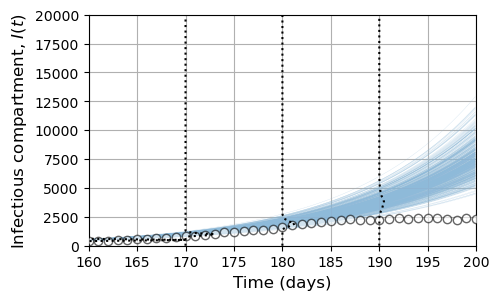

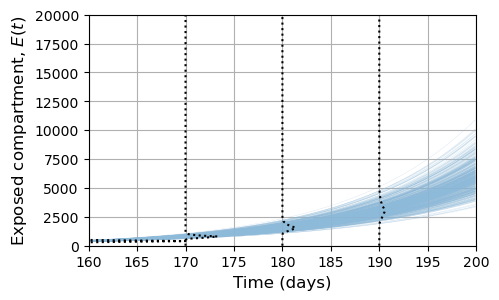

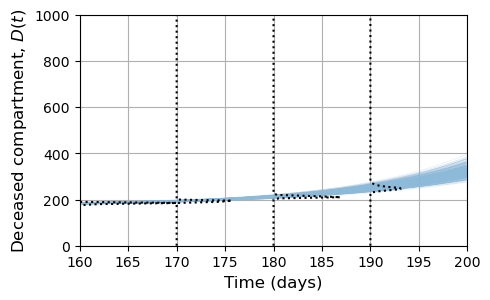

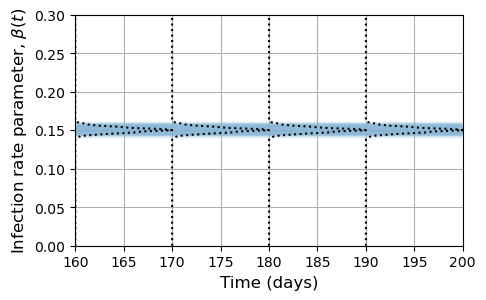

In [4]:
pred_low = int(d_cut*ndiv)

pred_high = int(tlim*ndiv)

Nsamples = 500

for ns in range(Nsamples):


##### For Toronto
    a0 = samples[0,ns]
    a1 = samples[1,ns]
    t1 =  20
    a2 = samples[2,ns]
    t2 =  35
    a3 =  samples[3,ns]
    t3 = 60
    a4 =  samples[4,ns]
    t4 = 80
    a5 =  samples[5,ns]
    t5 =  140


    beta_i[:,0] = a0 + a1/(1 + np.exp((t1-tmoh))) +  a2/(1 + np.exp((t2-tmoh))) + a3/(1 + np.exp((t3-tmoh)))  + a4/(1 + np.exp((t4-tmoh))) + a5/(1 + np.exp((t5-tmoh))) 
                #  + a6/(1 + np.exp((t6-tmoh))) + a7/(1 + np.exp((t7-tmoh))) 
    # + a8/(1 + np.exp((t8-tmoh)))
    beta_e[:,0] = beta_i[:,0]

    if ns == 0:
        beta_append=beta_e
    else:
        beta_append=np.hstack((beta_append,beta_e))

    # ax1.plot(tmoh[pred_low:pred_high], beta_i[pred_low:pred_high,0], color=(142/255,186/255,217/255), linewidth=0.2, label='_nolegend_')


    idxmoh = 0

    #### With mobility tensor   

    FoI = np.zeros((len(tmoh),1))
        
    for kk in range(1,len(tmoh)):

        FoI[kk,0] = beta_e[kk-1,0] * (E[kk-1,0] + I[kk-1,0]) / N[kk-1,0]

        S[kk,0] = S[kk-1,0] + dt*(- FoI[kk,0] * S[kk-1,0])
        E[kk,0] = E[kk-1,0] + dt*(FoI[kk,0]*S[kk-1,0] - (gamma_i + gamma_e)*E[kk-1,0])
        
        I[kk,0] = I[kk-1,0] + dt*(gamma_i*E[kk-1,0] - (gamma_r + gamma_d)*I[kk-1,0])
        R[kk,0] = R[kk-1,0] + dt*(gamma_e*E[kk-1,0] + gamma_r*I[kk-1,0])
        D[kk,0] = D[kk-1,0] + dt*(gamma_d*I[kk-1,0])
        N[kk,0] = S[kk,0] +  E[kk,0] + I[kk,0] + R[kk,0]


    if ns == 0:
        s_append=S[:,0]
        e_append=E[:,0]
        i_append=I[:,0]
        r_append=R[:,0]
        d_append=D[:,0]
    else:
        s_append=np.vstack((s_append,S[:,0]))
        e_append=np.vstack((e_append,E[:,0]))
        i_append=np.vstack((i_append,I[:,0]))
        r_append=np.vstack((r_append,R[:,0]))
        d_append=np.vstack((d_append,D[:,0]))


s_append=s_append.T
e_append=e_append.T
i_append=i_append.T
r_append=r_append.T
d_append=d_append.T

print(np.shape(i_append[pred_low:pred_high,:]))
print(np.shape(beta_append[pred_low:pred_high,:]))

Igrd = np.linspace(0,20000,201)
Ipdf_0 = st.gaussian_kde(i_append[1600,:],bw_method = 0.2)
Ipdf_5 = st.gaussian_kde(i_append[1700,:],bw_method = 0.2)
Ipdf_10 = st.gaussian_kde(i_append[1800,:],bw_method = 0.2)
Ipdf_15 = st.gaussian_kde(i_append[1900,:],bw_method = 0.2)
# Ipdf_20 = st.gaussian_kde(i_append[2000,:],bw_method = 0.2)
Imax = np.max([Ipdf_0(Igrd),Ipdf_5(Igrd),Ipdf_10(Igrd),Ipdf_15(Igrd)])
# Imax = np.max([Ipdf_0(Igrd),Ipdf_5(Igrd),Ipdf_10(Igrd),Ipdf_15(Igrd),Ipdf_20(Igrd)])


Egrd = np.linspace(0,20000,201)
Epdf_0 = st.gaussian_kde(e_append[1600,:],bw_method = 0.2)
Epdf_5 = st.gaussian_kde(e_append[1700,:],bw_method = 0.2)
Epdf_10 = st.gaussian_kde(e_append[1800,:],bw_method = 0.2)
Epdf_15 = st.gaussian_kde(e_append[1900,:],bw_method = 0.2)
# Ipdf_20 = st.gaussian_kde(i_append[2000,:],bw_method = 0.2)
Emax = np.max([Epdf_0(Egrd),Epdf_5(Egrd),Epdf_10(Egrd),Epdf_15(Egrd)])
# Imax = np.max([Ipdf_0(Igrd),Ipdf_5(Igrd),Ipdf_10(Igrd),Ipdf_15(Igrd),Ipdf_20(Igrd)])



Dgrd = np.linspace(0,1000,201)
Dpdf_0 = st.gaussian_kde(d_append[1600,:],bw_method = 0.2)
Dpdf_5 = st.gaussian_kde(d_append[1700,:],bw_method = 0.2)
Dpdf_10 = st.gaussian_kde(d_append[1800,:],bw_method = 0.2)
Dpdf_15 = st.gaussian_kde(d_append[1900,:],bw_method = 0.2)
# Ipdf_20 = st.gaussian_kde(i_append[2000,:],bw_method = 0.2)
Dmax = np.max([Dpdf_0(Dgrd),Dpdf_5(Dgrd),Dpdf_10(Dgrd),Dpdf_15(Dgrd)])
# Imax = np.max([Ipdf_0(Igrd),Ipdf_5(Igrd),Ipdf_10(Igrd),Ipdf_15(Igrd),Ipdf_20(Igrd)])



Bgrd = np.linspace(0,0.3,201)
Bpdf_0 = st.gaussian_kde(beta_append[1600,:],bw_method = 0.2)
Bpdf_5 = st.gaussian_kde(beta_append[1700,:],bw_method = 0.2)
Bpdf_10 = st.gaussian_kde(beta_append[1800,:],bw_method = 0.2)
Bpdf_15 = st.gaussian_kde(beta_append[1900,:],bw_method = 0.2)
# Bpdf_20 = st.gaussian_kde(beta_append[2000,:],bw_method = 0.2)
Bmax = np.max([Bpdf_0(Igrd),Bpdf_5(Bgrd),Bpdf_10(Bgrd),Bpdf_15(Bgrd)])
# Bmax = np.max([Bpdf_0(Bgrd),Bpdf_5(Bgrd),Bpdf_10(Bgrd),Bpdf_15(Bgrd),Ipdf_20(Bgrd)])

t_data = np.arange(0,201)

f, ax = plt.subplots(1, figsize=(5,3))#15,3
plt.plot(tmoh[pred_low:pred_high], i_append[pred_low:pred_high,:], color=(142/255,186/255,217/255,0.5), linewidth=0.2, label='_nolegend_')
# plt.plot(tmoh[pred_low:pred_high], all_truth[pred_low:pred_high,2], color='tab:red',linestyle='--', label='Truth')
plt.scatter(t_data[160:201],x_data[160:201],color='w',edgecolors='k',zorder=3,alpha=0.6,label='Data')
# plt.plot(160+tlist[0,:],mean_i1*2794356,linewidth=2,c='tab:blue',zorder=2)
# plt.plot(tmoh[pred_low:pred_high], all_truth[pred_low:pred_high,2],linewidth=2,c='tab:red',linestyle='--')
# plt.axvline(160,linestyle='--',c='k')
# plt.fill_between(272+t,x_mean[1,:]+3*np.sqrt(x_var[5,:]),x_mean[1,:]-3*np.sqrt(x_var[5,:]),facecolor='tab:blue',alpha=0.25,zorder=0)
# plt.plot([10,10],[-100,100],'k:',linewidth=1.5)
plt.grid(True)
plt.plot(160+Ipdf_0(Igrd)*10/Imax,Igrd,linewidth=1.5,c='k',linestyle=':',zorder=3)
plt.plot(170+Ipdf_5(Igrd)*10/Imax,Igrd,linewidth=1.5,c='k',linestyle=':',zorder=3)
plt.plot(180+Ipdf_10(Igrd)*10/Imax,Igrd,linewidth=1.5,c='k',linestyle=':',zorder=3)
plt.plot(190+Ipdf_15(Igrd)*10/Imax,Igrd,linewidth=1.5,c='k',linestyle=':',zorder=3)
# plt.plot(200+Ipdf_20(Igrd)*10/Imax,Igrd*2794356,linewidth=1.5,c='k',linestyle=':',zorder=3)
# plt.xticks([272, 279, 286,293,300])
plt.xlim([160,200])
plt.ylim([0,2e4])
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel(r'Infectious compartment, $I(t)$', fontsize=12)
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), fancybox=True, shadow=True, ncol=3, fontsize=12)
plt.savefig(f'{figpath}/forecast_i_sigmoid_case2.pdf',bbox_inches='tight')






f, ax = plt.subplots(1, figsize=(5,3))#15,3
plt.plot(tmoh[pred_low:pred_high], e_append[pred_low:pred_high,:], color=(142/255,186/255,217/255,0.5), linewidth=0.2, label='_nolegend_')
# plt.plot(tmoh[pred_low:pred_high], all_truth[pred_low:pred_high,1], color='tab:red',linestyle='--', label='Truth')
# plt.plot(160+tlist[0,:],mean_i1*2794356,linewidth=2,c='tab:blue',zorder=2)
# plt.plot(tmoh[pred_low:pred_high], all_truth[pred_low:pred_high,1],linewidth=2,c='tab:red',linestyle='--')
# plt.axvline(160,linestyle='--',c='k')
# plt.fill_between(272+t,x_mean[1,:]+3*np.sqrt(x_var[5,:]),x_mean[1,:]-3*np.sqrt(x_var[5,:]),facecolor='tab:blue',alpha=0.25,zorder=0)
# plt.plot([10,10],[-100,100],'k:',linewidth=1.5)
plt.grid(True)
plt.plot(160+Epdf_0(Egrd)*10/Emax,Egrd,linewidth=1.5,c='k',linestyle=':',zorder=3)
plt.plot(170+Epdf_5(Egrd)*10/Emax,Egrd,linewidth=1.5,c='k',linestyle=':',zorder=3)
plt.plot(180+Epdf_10(Egrd)*10/Emax,Egrd,linewidth=1.5,c='k',linestyle=':',zorder=3)
plt.plot(190+Epdf_15(Egrd)*10/Emax,Egrd,linewidth=1.5,c='k',linestyle=':',zorder=3)
# plt.plot(200+Ipdf_20(Igrd)*10/Imax,Igrd*2794356,linewidth=1.5,c='k',linestyle=':',zorder=3)
# plt.xticks([272, 279, 286,293,300])
plt.xlim([160,200])
plt.ylim([0,2e4])
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel(r'Exposed compartment, $E(t)$', fontsize=12)
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), fancybox=True, shadow=True, ncol=3, fontsize=12)
plt.savefig(f'{figpath}/forecast_e_sigmoid_case2.pdf',bbox_inches='tight')




f, ax = plt.subplots(1, figsize=(5,3))#15,3
plt.plot(tmoh[pred_low:pred_high], d_append[pred_low:pred_high,:], color=(142/255,186/255,217/255,0.5), linewidth=0.2, label='_nolegend_')
# plt.plot(tmoh[pred_low:pred_high], all_truth[pred_low:pred_high,4], color='tab:red',linestyle='--', label='Truth')
# plt.plot(160+tlist[0,:],mean_i1*2794356,linewidth=2,c='tab:blue',zorder=2)
# plt.plot(tmoh[pred_low:pred_high], all_truth[pred_low:pred_high,4],linewidth=2,c='tab:red',linestyle='--')
# plt.axvline(160,linestyle='--',c='k')
# plt.fill_between(272+t,x_mean[1,:]+3*np.sqrt(x_var[5,:]),x_mean[1,:]-3*np.sqrt(x_var[5,:]),facecolor='tab:blue',alpha=0.25,zorder=0)
# plt.plot([10,10],[-100,100],'k:',linewidth=1.5)
plt.grid(True)
plt.plot(160+Dpdf_0(Dgrd)*10/Dmax,Dgrd,linewidth=1.5,c='k',linestyle=':',zorder=3)
plt.plot(170+Dpdf_5(Dgrd)*10/Dmax,Dgrd,linewidth=1.5,c='k',linestyle=':',zorder=3)
plt.plot(180+Dpdf_10(Dgrd)*10/Dmax,Dgrd,linewidth=1.5,c='k',linestyle=':',zorder=3)
plt.plot(190+Dpdf_15(Dgrd)*10/Dmax,Dgrd,linewidth=1.5,c='k',linestyle=':',zorder=3)
# plt.plot(200+Ipdf_20(Igrd)*10/Imax,Igrd*2794356,linewidth=1.5,c='k',linestyle=':',zorder=3)
# plt.xticks([272, 279, 286,293,300])
plt.xlim([160,200])
plt.ylim([0,1000])
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel(r'Deceased compartment, $D(t)$', fontsize=12)
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), fancybox=True, shadow=True, ncol=3, fontsize=12)
plt.savefig(f'{figpath}/forecast_d_sigmoid_case2.pdf',bbox_inches='tight')





f, ax = plt.subplots(1, figsize=(5,3))#15,3
plt.plot(tmoh[pred_low:pred_high], beta_append[pred_low:pred_high,:], color=(142/255,186/255,217/255,0.5), linewidth=0.2, label='_nolegend_')
# plt.plot(160+tlist[0,:],mean_b1,linewidth=2,c='tab:blue',zorder=3)
# plt.plot(tmoh[pred_low:pred_high], beta_truth[pred_low:pred_high],linewidth=2,c='tab:red',linestyle='--', label='Truth')
# plt.fill_between(272+t,x_mean[3,:]+3*np.sqrt(x_var[15,:]),x_mean[3,:]-3*np.sqrt(x_var[15,:]),facecolor='tab:blue',alpha=0.25,zorder=0)
# plt.plot([10,10],[-100,100],'k:',linewidth=1.5)
plt.grid(True)
# plt.xticks([272, 279, 286,293,300])
plt.plot(160+Bpdf_0(Bgrd)*10/Bmax,Bgrd,linewidth=1.5,c='k',linestyle=':',zorder=3)
plt.plot(170+Bpdf_5(Bgrd)*10/Bmax,Bgrd,linewidth=1.5,c='k',linestyle=':',zorder=3)
plt.plot(180+Bpdf_10(Bgrd)*10/Bmax,Bgrd,linewidth=1.5,c='k',linestyle=':',zorder=3)
plt.plot(190+Bpdf_15(Bgrd)*10/Bmax,Bgrd,linewidth=1.5,c='k',linestyle=':',zorder=3)
# plt.plot(200+Bpdf_20(Bgrd)*10/Bmax,Bgrd,linewidth=1.5,c='k',linestyle=':',zorder=3)
plt.xlim([160,200])
plt.ylim([0,0.3])
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel(r'Infection rate parameter, $\beta(t)$', fontsize=12)
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), fancybox=True, shadow=True, ncol=3, fontsize=12)
plt.savefig(f'{figpath}/forecast_beta_sigmoid_case2.pdf',bbox_inches='tight')


In [ ]:
# ###### Plotting PDFS ##########

# from scipy.stats import gaussian_kde

# x1 = np.linspace(0,1000, 100)

# kde = gaussian_kde(I_pdf[0,:], bw_method='scott')

# kde_t1 = kde(x1)

# fig,ax = plt.subplots(figsize=(6, 4))
# plt.plot(x1,kde_t1,label = '160 days')
# plt.xlabel('$I$')
# plt.ylabel('$p(I)$')
# plt.autoscale(enable=True, axis='x', tight=True)
# plt.legend()
# plt.savefig(f'{figpath}/pdf_0.pdf',bbox_inches='tight' )
# plt.show()


# x2 = np.linspace(0,3000, 100)

# kde = gaussian_kde(I_pdf[9,:], bw_method='scott')

# kde_t2 = kde(x2)

# fig,ax = plt.subplots(figsize=(6, 4))
# plt.plot(x2,kde_t2,label = '170 days')
# plt.xlabel('$I$')
# plt.ylabel('$p(I)$')
# plt.autoscale(enable=True, axis='x', tight=True)
# plt.legend()
# plt.savefig(f'{figpath}/pdf_10.pdf', bbox_inches='tight')
# plt.show()



# x3 = np.linspace(0,5000, 100)

# kde = gaussian_kde(I_pdf[19,:], bw_method='scott')

# kde_t3 = kde(x3)

# fig,ax = plt.subplots(figsize=(6, 4))
# plt.plot(x3,kde_t3,label = '180 days')
# plt.xlabel('$I$')
# plt.ylabel('$p(I)$')
# plt.autoscale(enable=True, axis='x', tight=True)
# plt.legend()
# plt.savefig(f'{figpath}/pdf_20.pdf', bbox_inches='tight')
# plt.show()




# x4 = np.linspace(0,10000, 100)

# kde = gaussian_kde(I_pdf[29,:], bw_method='scott')

# kde_t4 = kde(x4)

# fig,ax = plt.subplots(figsize=(6, 4))
# plt.plot(x4,kde_t4,label = '190 days')
# plt.xlabel('$I$')
# plt.ylabel('$p(I)$')
# plt.autoscale(enable=True, axis='x', tight=True)
# plt.legend()
# plt.savefig(f'{figpath}/pdf_30.pdf', bbox_inches='tight')
# plt.show()




/var/folders/lr/4h04vl_92s3d0hrwg37l8g740000gn/T/ipykernel_53697/1022795398.py:20: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  res = minimize(kde_fun,true, method='nelder-mead',options={'xatol': 1e-8, 'disp': True})


0.14781418833108798 0.0015297198951948823 0.14783031849174122
-0.1058129722069669 0.004438778811101723 -0.10515175725793796
0.059412790306794805 0.004646366195381395 0.058380538177045
-0.06119356460531 0.0034220010666387354 -0.06142836594369892


/var/folders/lr/4h04vl_92s3d0hrwg37l8g740000gn/T/ipykernel_53697/1022795398.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f, ax = plt.subplots(1, figsize=(3,3))


0.021092904283314708 0.00220671392465194 0.022040017228080994
0.08913685240788592 0.003828528029986115 0.08865827552235177


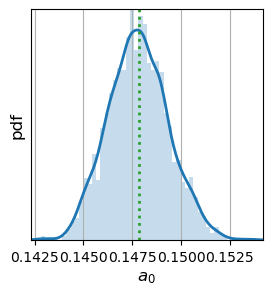

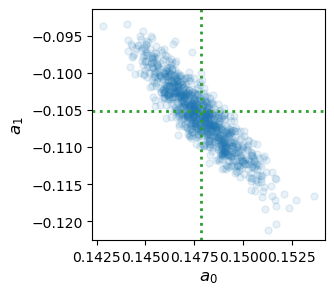

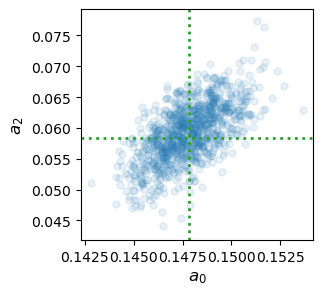

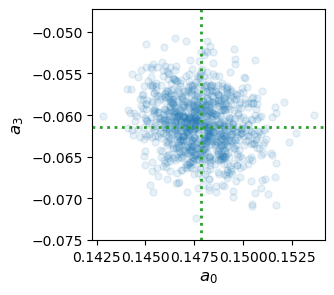

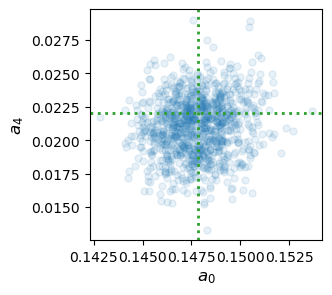

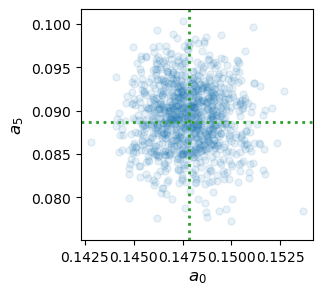

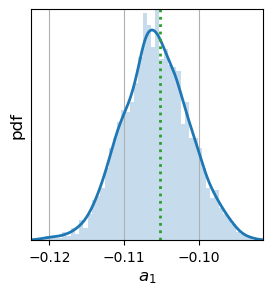

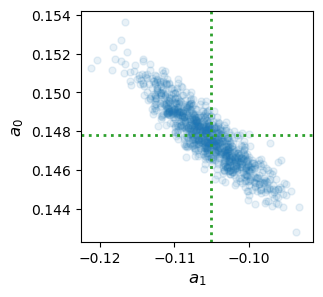

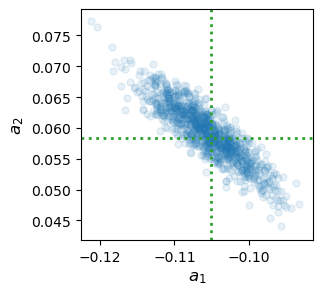

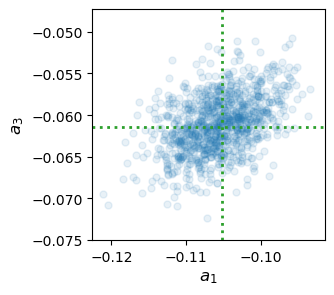

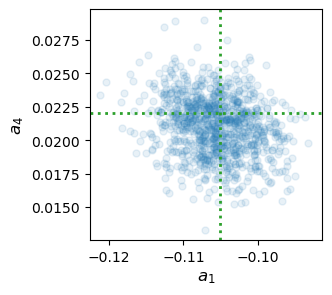

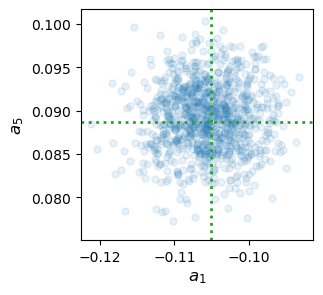

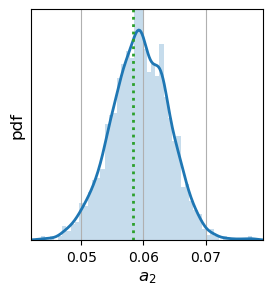

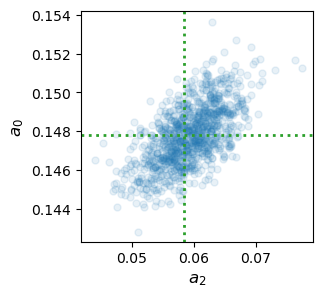

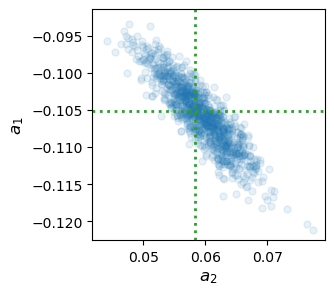

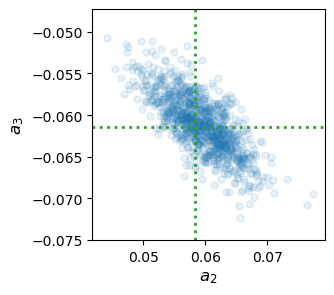

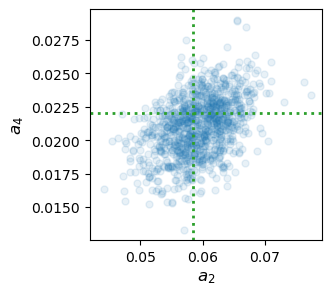

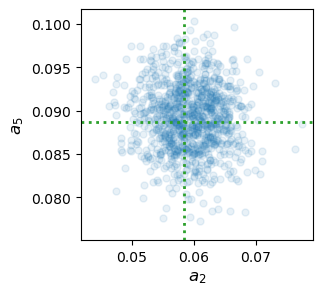

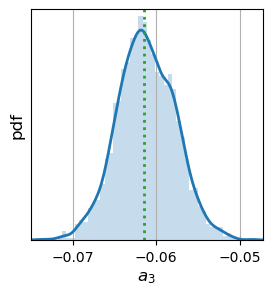

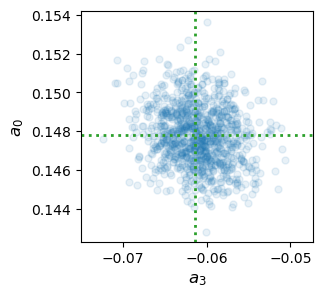

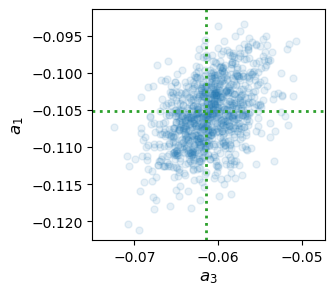

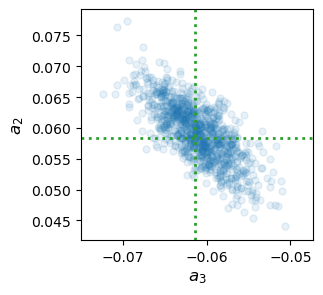

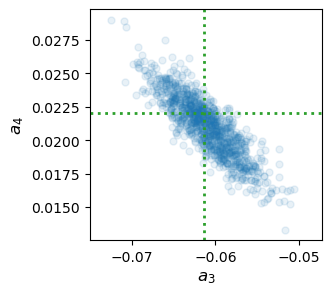

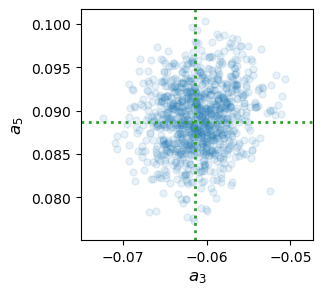

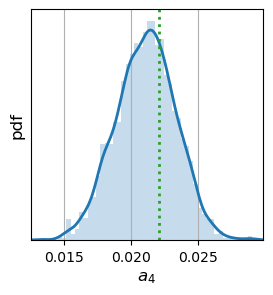

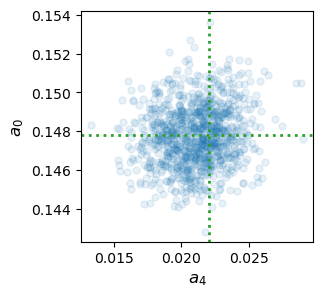

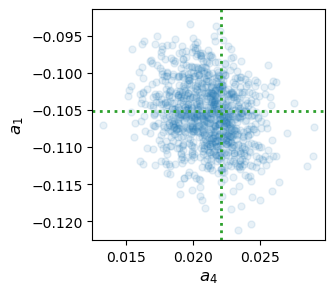

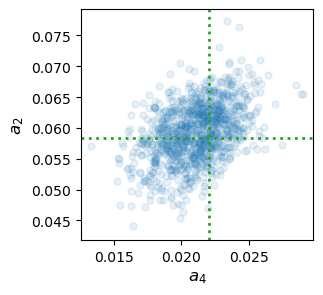

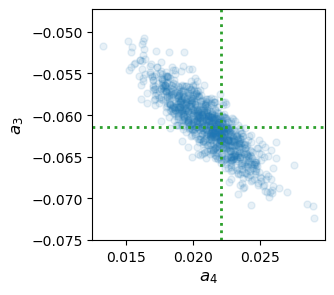

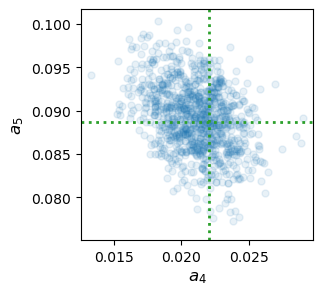

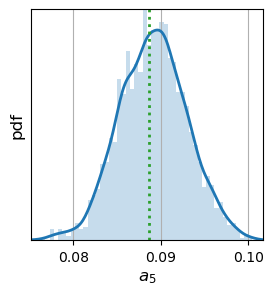

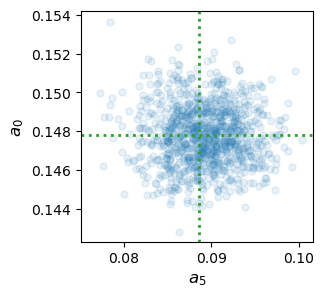

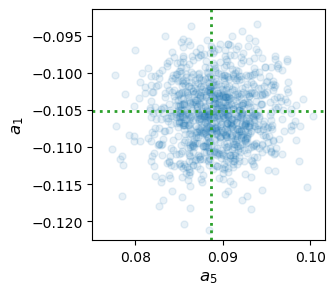

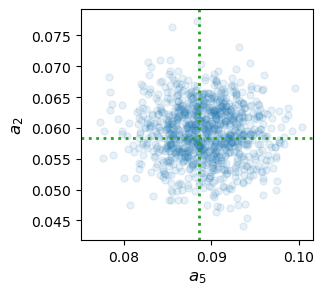

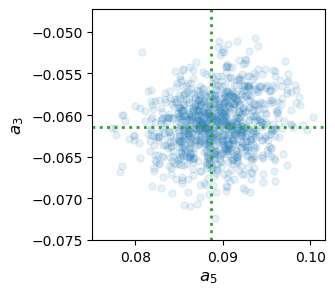

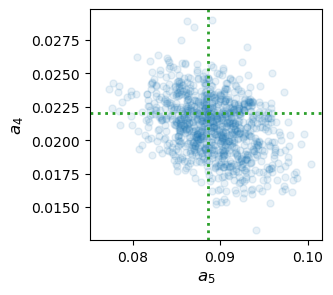

In [5]:
## Model Full
skip = 2

samples = np.loadtxt('../../data/muVec_real_case2.dat')
# samples = np.loadtxt('../../data/muVec_real.dat')
label = [r'$a_0$',r'$a_1$',r'$a_2$',r'$a_3$',r'$a_4$',r'$a_5$',r'$a_6$']
Npar = len(samples[:,0])
# true = [0.15,-0.1,0.05,-0.07,0.035,0.08]

### For real data
true = [0.145,-0.1,0.05,-0.06,0.022,0.09]


find_map = 1
if find_map == 1:
  from scipy.optimize import minimize
  kde = st.gaussian_kde(samples)
  def kde_fun(x):
    return -kde(x)
  res = minimize(kde_fun,true, method='nelder-mead',options={'xatol': 1e-8, 'disp': True})
  # print(res.x)
  maps = res.x
  # np.savetxt('chains/ModelSIRS_SIS-map.dat',maps)

for ii in range(len(samples[:,0])):
  xmin,xmax = np.min(samples[ii,:]), np.max(samples[ii,:])
  # if param_true[ii] < xmin:
  #   xmin = param_true[ii]
  # elif  param_true[ii] > xmax:
  #   xmax = param_true[ii]

  print(np.mean(samples[ii,:]),np.std(samples[ii,:]),maps[ii])

  xmean = (xmin + xmax)/2
  xrang = (xmax - xmin)
  x_low = np.max([xmean-0.55*xrang])
  x_up = np.min([xmean+0.55*xrang])

  f, ax = plt.subplots(1, figsize=(3,3))
  Xpdf = st.gaussian_kde(samples[ii,:],bw_method = 0.2)
  # print(Xpdf.silverman_factor())
  # Xgrd = np.linspace(np.min(samples[ii,:]),np.max(samples[ii,:]))
  Xgrd = np.linspace(x_low,x_up,201)
  pdfmax = max(Xpdf(Xgrd))
  plt.plot(Xgrd,Xpdf(Xgrd),color='tab:blue',linewidth=2)
  plt.hist(samples[ii,:],bins=50,density=True,alpha=0.25)

  ### Uncomment for Synthetic data
#   plt.plot([true[ii],true[ii]],[0,1.1*pdfmax],c='tab:red',linewidth=2,linestyle='--')
  plt.plot([maps[ii],maps[ii]],[0,1.1*pdfmax],c='tab:green',linewidth=2,linestyle=':')
  myYlim = [0.0, 1.1*pdfmax]
  plt.ylabel('pdf', fontsize=12)
  plt.xlabel(label[ii], fontsize=12)
  plt.ylim(myYlim)
  plt.xlim([x_low,x_up])
  plt.yticks([])
  plt.grid(True)
  plt.savefig(f'{figpath}/real_mpdf_'+ str(ii)+'.pdf',bbox_inches='tight')
  # plt.close()

  for jj in range(Npar):
   if ii != jj:
      ymin,ymax = np.min(samples[jj,:]), np.max(samples[jj,:])
      ymean = (ymin + ymax)/2
      yrang = (ymax - ymin)
      y_low = np.max([ymean-0.55*yrang])
      y_up = np.min([ymean+0.55*yrang])

      f, ax = plt.subplots(1, figsize=(3,3))
      plt.scatter(samples[ii,::skip],samples[jj,::skip],alpha=0.1,s=25)
      plt.plot([x_low,x_up],[maps[jj],maps[jj]],c='tab:green',linewidth=2,linestyle=':')
      plt.plot([maps[ii],maps[ii]],[y_low,y_up],c='tab:green',linewidth=2,linestyle=':')
      plt.xlim([x_low,x_up])
      plt.ylim([y_low,y_up])
      plt.xlabel(label[ii],fontsize=12)
      plt.ylabel(label[jj],fontsize=12)
      plt.savefig(f'{figpath}/real_jpdf_'+ str(ii)+str(jj)+'.pdf',bbox_inches='tight')
      # plt.close()